In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm.notebook import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet34, ResNet34_Weights
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Set path to dataset
DATA_DIR = '/kaggle/input/chest-xray-pneumonia/chest_xray/'
if not os.path.exists(DATA_DIR):
    DATA_DIR = './chest_xray/'

print(f"Dataset path: {DATA_DIR}")
train_dir = os.path.join(DATA_DIR, 'train')
test_dir = os.path.join(DATA_DIR, 'test')
val_dir = os.path.join(DATA_DIR, 'val')

Dataset path: /kaggle/input/chest-xray-pneumonia/chest_xray/


Dataset structure:
Train directory: /kaggle/input/chest-xray-pneumonia/chest_xray/train
Test directory: /kaggle/input/chest-xray-pneumonia/chest_xray/test
Validation directory: /kaggle/input/chest-xray-pneumonia/chest_xray/val

Number of images in each category:
Train set: Normal = 1341, Pneumonia = 3875
Test set: Normal = 234, Pneumonia = 390
Validation set: Normal = 8, Pneumonia = 8

Class weights to handle imbalance: Normal = 1.8497, Pneumonia = 0.6852


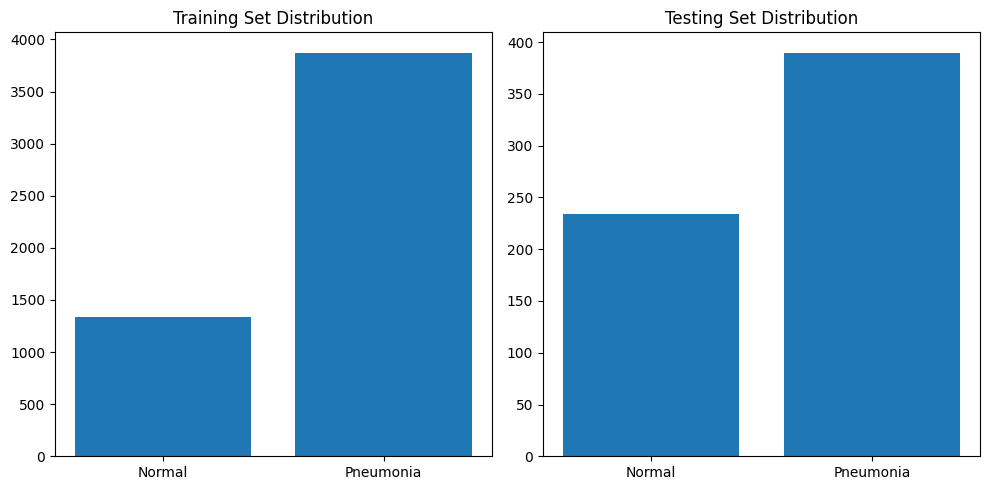

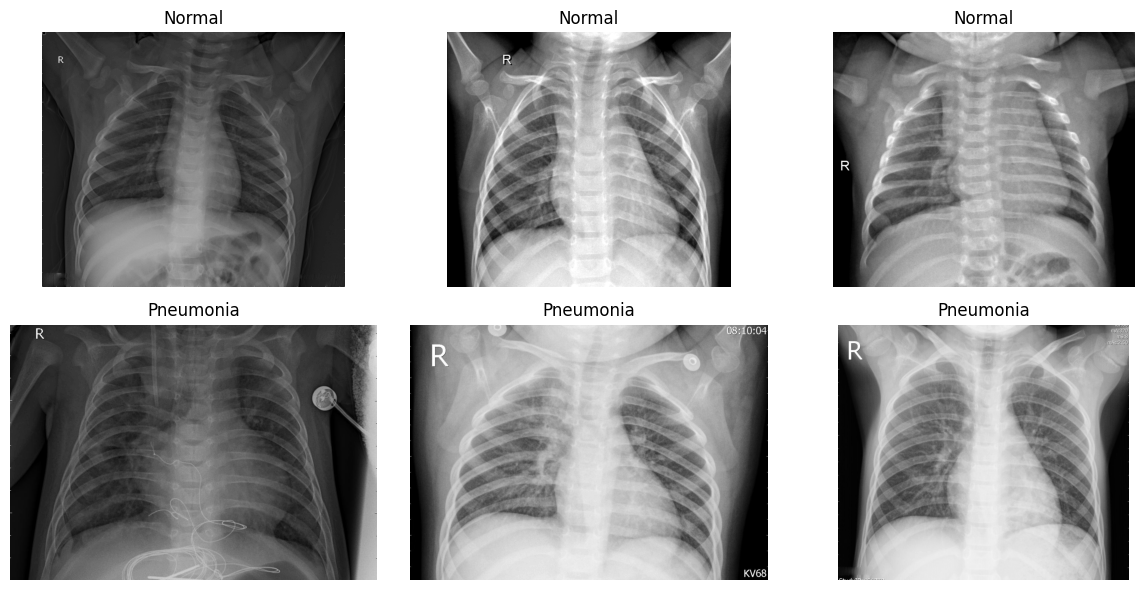

In [3]:
# Explore dataset structure and visualization
def explore_dataset():
    print("Dataset structure:")
    print(f"Train directory: {train_dir}")
    print(f"Test directory: {test_dir}")
    print(f"Validation directory: {val_dir}")
    
    # Count images in each category
    normal_train = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
    pneumonia_train = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
    
    normal_test = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
    pneumonia_test = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
    
    normal_val = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
    pneumonia_val = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
    
    print("\nNumber of images in each category:")
    print(f"Train set: Normal = {normal_train}, Pneumonia = {pneumonia_train}")
    print(f"Test set: Normal = {normal_test}, Pneumonia = {pneumonia_test}")
    print(f"Validation set: Normal = {normal_val}, Pneumonia = {pneumonia_val}")
    
    # Calculate class weights for handling imbalance
    total_normal = normal_train + normal_test + normal_val
    total_pneumonia = pneumonia_train + pneumonia_test + pneumonia_val
    total_images = total_normal + total_pneumonia
    
    weight_normal = total_images / (2 * total_normal)
    weight_pneumonia = total_images / (2 * total_pneumonia)
    
    print(f"\nClass weights to handle imbalance: Normal = {weight_normal:.4f}, Pneumonia = {weight_pneumonia:.4f}")
    
    # Visualize class distribution
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.bar(['Normal', 'Pneumonia'], [normal_train, pneumonia_train])
    plt.title('Training Set Distribution')
    plt.subplot(1, 2, 2)
    plt.bar(['Normal', 'Pneumonia'], [normal_test, pneumonia_test])
    plt.title('Testing Set Distribution')
    plt.tight_layout()
    plt.show()
    
    # Display sample images
    plt.figure(figsize=(12, 6))
    
    # Normal samples
    normal_files = os.listdir(os.path.join(train_dir, 'NORMAL'))
    for i in range(3):
        plt.subplot(2, 3, i+1)
        img_path = os.path.join(train_dir, 'NORMAL', normal_files[i])
        img = plt.imread(img_path)
        plt.imshow(img, cmap='gray')
        plt.title(f'Normal')
        plt.axis('off')
    
    # Pneumonia samples
    pneumonia_files = os.listdir(os.path.join(train_dir, 'PNEUMONIA'))
    for i in range(3):
        plt.subplot(2, 3, i+4)
        img_path = os.path.join(train_dir, 'PNEUMONIA', pneumonia_files[i])
        img = plt.imread(img_path)
        plt.imshow(img, cmap='gray')
        plt.title(f'Pneumonia')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return weight_normal, weight_pneumonia

class_weights = explore_dataset()

In [4]:
# Custom Dataset and Data Augmentation
class ChestXRayDataset(Dataset):
    def __init__(self, folder_dir, transform=None, phase='train'):
        self.folder_dir = folder_dir
        self.transform = transform
        self.phase = phase
        
        # Get file paths and labels
        self.normal_files = [os.path.join(folder_dir, 'NORMAL', x) for x in os.listdir(os.path.join(folder_dir, 'NORMAL'))]
        self.pneumonia_files = [os.path.join(folder_dir, 'PNEUMONIA', x) for x in os.listdir(os.path.join(folder_dir, 'PNEUMONIA'))]
        
        # Balance dataset for training (optional)
        if phase == 'train':
            # If normal class is smaller, oversample it
            if len(self.normal_files) < len(self.pneumonia_files):
                ratio = len(self.pneumonia_files) // len(self.normal_files)
                self.normal_files = self.normal_files * ratio
            # If pneumonia class is smaller, oversample it
            elif len(self.pneumonia_files) < len(self.normal_files):
                ratio = len(self.normal_files) // len(self.pneumonia_files)
                self.pneumonia_files = self.pneumonia_files * ratio
        
        self.all_files = self.normal_files + self.pneumonia_files
        self.labels = [0] * len(self.normal_files) + [1] * len(self.pneumonia_files)
        
        # Shuffle data
        indices = list(range(len(self.all_files)))
        np.random.shuffle(indices)
        self.all_files = [self.all_files[i] for i in indices]
        self.labels = [self.labels[i] for i in indices]
        
    def __len__(self):
        return len(self.all_files)
    
    def __getitem__(self, idx):
        img_path = self.all_files[idx]
        label = self.labels[idx]
        
        # Load image
        img = Image.open(img_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Define transformations for each phase
def get_transforms(img_size=224):
    # Advanced augmentation for training
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Minimal processing for validation and testing
    val_test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_test_transform

In [5]:
# Data Loaders
def get_data_loaders(batch_size=32, img_size=224):
    train_transform, val_test_transform = get_transforms(img_size)
    
    # Create datasets
    train_dataset = ChestXRayDataset(train_dir, transform=train_transform, phase='train')
    val_dataset = ChestXRayDataset(val_dir, transform=val_test_transform, phase='val')
    test_dataset = ChestXRayDataset(test_dir, transform=val_test_transform, phase='test')
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, val_loader, test_loader

# Initialize data loaders
BATCH_SIZE = 32
IMG_SIZE = 224
train_loader, val_loader, test_loader = get_data_loaders(BATCH_SIZE, IMG_SIZE)

# Display batch information
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


In [6]:
# Vision Transformer (ViT) Model Definition
class PatchEmbedding(nn.Module):
    """Split image into patches and embed them."""
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )
    
    def forward(self, x):
        """Forward pass.
        
        Args:
            x: Input tensor of shape [batch_size, channels, img_size, img_size]
            
        Returns:
            Tensor of shape [batch_size, n_patches, embed_dim]
        """
        batch_size, channels, h, w = x.shape
        assert h == self.img_size and w == self.img_size, \
            f"Input image size ({h}*{w}) doesn't match model ({self.img_size}*{self.img_size})"
        
        # Extract patches: [B, C, H, W] -> [B, embed_dim, n_patches_sqrt, n_patches_sqrt]
        x = self.proj(x)
        # Flatten patches: [B, embed_dim, n_patches_sqrt, n_patches_sqrt] -> [B, embed_dim, n_patches]
        x = x.flatten(2)
        # Transpose to [B, n_patches, embed_dim]
        x = x.transpose(1, 2)
        
        return x

class Attention(nn.Module):
    """Multi-head self-attention module."""
    def __init__(self, embed_dim=768, num_heads=12, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = embed_dim // num_heads
        self.scale = head_dim ** -0.5
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(proj_drop)
        
        # Store attention weights for visualization
        self.attn_weights = None
    
    def forward(self, x):
        """Forward pass.
        
        Args:
            x: Input tensor of shape [batch_size, n_patches+1, embed_dim]
            
        Returns:
            Tensor of shape [batch_size, n_patches+1, embed_dim]
        """
        batch_size, n_tokens, embed_dim = x.shape
        
        # Get query, key, value projections
        qkv = self.qkv(x).reshape(batch_size, n_tokens, 3, self.num_heads, embed_dim // self.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, batch_size, num_heads, n_tokens, head_dim]
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Calculate attention scores
        attn = (q @ k.transpose(-2, -1)) * self.scale  # [batch_size, num_heads, n_tokens, n_tokens]
        attn = attn.softmax(dim=-1)
        self.attn_weights = attn.detach()  # Store for visualization
        attn = self.attn_drop(attn)
        
        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(batch_size, n_tokens, embed_dim)
        x = self.proj(x)
        x = self.proj_drop(x)
        
        return x

class TransformerBlock(nn.Module):
    """Transformer encoder block."""
    def __init__(self, embed_dim=768, num_heads=12, mlp_ratio=4.0, qkv_bias=True, 
                 drop=0., attn_drop=0., act_layer=nn.GELU):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = Attention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            attn_drop=attn_drop,
            proj_drop=drop
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            act_layer(),
            nn.Dropout(drop),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(drop)
        )
    
    def forward(self, x):
        """Forward pass with residual connections.
        
        Args:
            x: Input tensor of shape [batch_size, n_patches+1, embed_dim]
            
        Returns:
            Tensor of shape [batch_size, n_patches+1, embed_dim]
        """
        # Multi-head self-attention with residual connection
        x = x + self.attn(self.norm1(x))
        # MLP with residual connection
        x = x + self.mlp(self.norm2(x))
        return x

In [7]:
# Hybrid ViT-CNN Model
class HybridViTCNN(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=2, 
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, qkv_bias=True, 
                 drop_rate=0.1, attn_drop_rate=0.0):
        super().__init__()
        
        # CNN Backbone (ResNet34)
        self.resnet = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        # Remove the final classification layer
        self.cnn_features = nn.Sequential(*list(self.resnet.children())[:-2])
        
        # Vision Transformer Components
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        
        # Patch embedding layer
        self.patch_embed = PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim
        )
        
        # Number of patches
        self.num_patches = self.patch_embed.n_patches
        
        # Class token and position embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop_rate,
                attn_drop=attn_drop_rate
            )
            for _ in range(depth)
        ])
        
        # Dropout and layer normalization
        self.drop = nn.Dropout(drop_rate)
        self.norm = nn.LayerNorm(embed_dim)
        
        # Adaptive Multi-Resolution Fusion
        # This fuses CNN features with transformer features at multiple scales
        self.cnn_projection = nn.Conv2d(512, embed_dim, kernel_size=1)
        self.fusion_layer = nn.Sequential(
            nn.Linear(embed_dim * 2, embed_dim),
            nn.GELU(),
            nn.Dropout(drop_rate),
            nn.Linear(embed_dim, embed_dim)
        )
        
        # Hierarchical Attention Pooling
        # This allows the model to focus on different regions of the image at different levels
        self.attn_pool1 = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        self.attn_pool2 = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        # Classification head
        self.head = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.GELU(),
            nn.Dropout(drop_rate),
            nn.Linear(512, num_classes)
        )
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        # Initialize position embeddings and class token
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        
        # Initialize weights for all linear layers and layer norms
        self.apply(self._init_weights_layer)
    
    def _init_weights_layer(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
    
    def forward_features(self, x):
        """
        Extract features using both CNN and transformer paths.
        """
        batch_size = x.shape[0]
        
        # CNN path: Extract features using ResNet
        cnn_features = self.cnn_features(x)  # [B, 512, H/32, W/32]
        
        # Transformer path: Extract patches and embed them
        # [B, C, H, W] -> [B, num_patches, embed_dim]
        x = self.patch_embed(x)
        
        # Add class token
        # [1, 1, embed_dim] -> [B, 1, embed_dim]
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        # [B, num_patches, embed_dim] -> [B, num_patches + 1, embed_dim]
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Add position embeddings
        x = x + self.pos_embed
        x = self.drop(x)
        
        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Apply layer normalization
        x = self.norm(x)
        
        return x, cnn_features
    
    def forward(self, x):
        """Forward pass through the hybrid model."""
        batch_size = x.shape[0]
        
        # Get features from both paths
        transformer_features, cnn_features = self.forward_features(x)
        
        # Adaptive Multi-Resolution Fusion
        # Project CNN features to embedding dimension
        cnn_proj = self.cnn_projection(cnn_features)  # [B, embed_dim, H/32, W/32]
        cnn_proj = cnn_proj.flatten(2).transpose(1, 2)  # [B, H*W/1024, embed_dim]
        
        # Apply hierarchical attention pooling to CNN features
        attn_weights1 = self.attn_pool1(cnn_proj)  # [B, H*W/1024, 1]
        attn_weights1 = F.softmax(attn_weights1, dim=1)
        cnn_pooled = torch.sum(cnn_proj * attn_weights1, dim=1)  # [B, embed_dim]
        
        # Extract class token from transformer features
        cls_token_out = transformer_features[:, 0]  # [B, embed_dim]
        
        # Apply hierarchical attention pooling to transformer patch tokens
        patch_tokens = transformer_features[:, 1:]  # [B, num_patches, embed_dim]
        attn_weights2 = self.attn_pool2(patch_tokens)  # [B, num_patches, 1]
        attn_weights2 = F.softmax(attn_weights2, dim=1)
        transformer_pooled = torch.sum(patch_tokens * attn_weights2, dim=1)  # [B, embed_dim]
        
        # Fuse CNN and transformer features
        fused_cls = torch.cat([cls_token_out, cnn_pooled], dim=1)  # [B, embed_dim*2]
        fused_features = self.fusion_layer(fused_cls)  # [B, embed_dim]
        
        # Combine with pooled transformer features
        final_features = fused_features + transformer_pooled  # [B, embed_dim]
        
        # Classification
        logits = self.head(final_features)
        
        return logits, attn_weights1, attn_weights2

In [8]:
# Training and Evaluation Functions
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc="Training")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs, _, _ = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        pbar.set_postfix({'loss': running_loss / (batch_idx + 1), 'acc': 100. * correct / total})
    
    # Calculate epoch statistics
    train_loss = running_loss / len(dataloader)
    train_acc = 100. * correct / total
    
    return train_loss, train_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation")
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs, _, _ = model(inputs)
            loss = criterion(outputs, targets)
            
            # Track statistics
            running_loss += loss.item()
            probs = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Store for metrics calculation
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability for class 1 (Pneumonia)
            
            # Update progress bar
            pbar.set_postfix({'loss': running_loss / (batch_idx + 1), 'acc': 100. * correct / total})
    
    # Calculate epoch statistics
    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total
    
    # Calculate additional metrics
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    
    return val_loss, val_acc, precision, recall, f1, all_targets, all_preds, all_probs

def plot_training_history(history):
    """Plot training and validation metrics."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot additional metrics
    plt.figure(figsize=(15, 5))
    plt.plot(history['val_precision'], label='Precision')
    plt.plot(history['val_recall'], label='Recall')
    plt.plot(history['val_f1'], label='F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Metrics')
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes=['Normal', 'Pneumonia']):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Display classification report
    print(classification_report(y_true, y_pred, target_names=classes))

def plot_roc_curve(y_true, y_score):
    """Plot ROC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def visualize_attention_maps(model, dataloader, device, num_samples=3):
    """Visualize attention maps from the model."""
    model.eval()
    
    # Get samples
    all_images = []
    all_labels = []
    
    for img, lbl in dataloader:
        all_images.append(img)
        all_labels.append(lbl)
        if len(all_images) >= 1:  # Just need one batch
            break
    
    # Get the first batch
    images = all_images[0]
    labels = all_labels[0]
    
    # Create a figure
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i in range(min(num_samples, len(images))):
        # Get an image and send to device
        img = images[i:i+1].to(device)
        label = labels[i].item()
        class_name = 'Normal' if label == 0 else 'Pneumonia'
        
        # Forward pass
        with torch.no_grad():
            outputs, attn1, attn2 = model(img)
            
        # Convert original image for display
        orig_img = images[i].permute(1, 2, 0).cpu().numpy()
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        orig_img = std * orig_img + mean
        orig_img = np.clip(orig_img, 0, 1)
        
        # Process attention maps - simplify to avoid issues
        # Just take the first attention map for visualization
        attn = attn2.cpu().numpy()[0]  # Get first sample
        attn = attn.reshape(int(np.sqrt(attn.shape[0])), int(np.sqrt(attn.shape[0])))
        
        # Resize attention map to match image size
        from skimage.transform import resize
        attention_map = resize(attn, (224, 224), order=1, mode='reflect')
        
        # Display original image
        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title(f'Original: {class_name}')
        axes[i, 0].axis('off')
        
        # Display attention map
        att_map = axes[i, 1].imshow(attention_map, cmap='jet')
        axes[i, 1].set_title('Attention Map')
        axes[i, 1].axis('off')
        
        # Create overlay
        # Apply a colormap to create an RGB representation of the attention map
        from matplotlib import cm
        colored_attention = cm.jet(attention_map)[:,:,:3]  # drop alpha channel
        
        # Create a weighted sum of the original image and colored attention map
        overlay = 0.7 * orig_img + 0.3 * colored_attention
        
        # Display overlay
        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title('Overlay')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

In [9]:
# Model Training
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=15):
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': []
    }
    
    best_val_acc = 0.0
    best_model_wts = model.state_dict()
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc, precision, recall, f1, _, _, _ = validate(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step()
        
        # Track history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(precision)
        history['val_recall'].append(recall)
        history['val_f1'].append(f1)
        
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
        print("-" * 50)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()
            # Save checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_acc': val_acc,
            }, 'best_model.pth')
    
    # Load best model
    model.load_state_dict(best_model_wts)
    
    return model, history

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 190MB/s]


Model parameters: 37,302,572
Epoch 1/15


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1461 | Train Acc: 91.76%
Val Loss: 0.0635 | Val Acc: 100.00% | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
--------------------------------------------------
Epoch 2/15


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0607 | Train Acc: 97.44%
Val Loss: 0.2224 | Val Acc: 93.75% | Precision: 0.8889 | Recall: 1.0000 | F1: 0.9412
--------------------------------------------------
Epoch 3/15


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0474 | Train Acc: 97.86%
Val Loss: 0.1183 | Val Acc: 100.00% | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
--------------------------------------------------
Epoch 4/15


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0355 | Train Acc: 98.44%
Val Loss: 0.0336 | Val Acc: 100.00% | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
--------------------------------------------------
Epoch 5/15


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0262 | Train Acc: 98.80%
Val Loss: 0.0379 | Val Acc: 100.00% | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
--------------------------------------------------
Epoch 6/15


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0207 | Train Acc: 99.15%
Val Loss: 0.1105 | Val Acc: 93.75% | Precision: 0.8889 | Recall: 1.0000 | F1: 0.9412
--------------------------------------------------
Epoch 7/15


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0131 | Train Acc: 99.44%
Val Loss: 0.0176 | Val Acc: 100.00% | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
--------------------------------------------------
Epoch 8/15


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0099 | Train Acc: 99.57%
Val Loss: 0.0599 | Val Acc: 100.00% | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
--------------------------------------------------
Epoch 9/15


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0062 | Train Acc: 99.77%
Val Loss: 0.1447 | Val Acc: 87.50% | Precision: 0.8000 | Recall: 1.0000 | F1: 0.8889
--------------------------------------------------
Epoch 10/15


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0038 | Train Acc: 99.85%
Val Loss: 0.2009 | Val Acc: 87.50% | Precision: 0.8000 | Recall: 1.0000 | F1: 0.8889
--------------------------------------------------
Epoch 11/15


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0041 | Train Acc: 99.80%
Val Loss: 0.2573 | Val Acc: 87.50% | Precision: 0.8000 | Recall: 1.0000 | F1: 0.8889
--------------------------------------------------
Epoch 12/15


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0040 | Train Acc: 99.85%
Val Loss: 0.3226 | Val Acc: 87.50% | Precision: 0.8000 | Recall: 1.0000 | F1: 0.8889
--------------------------------------------------
Epoch 13/15


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0048 | Train Acc: 99.80%
Val Loss: 0.1294 | Val Acc: 93.75% | Precision: 0.8889 | Recall: 1.0000 | F1: 0.9412
--------------------------------------------------
Epoch 14/15


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0130 | Train Acc: 99.47%
Val Loss: 0.1640 | Val Acc: 93.75% | Precision: 0.8889 | Recall: 1.0000 | F1: 0.9412
--------------------------------------------------
Epoch 15/15


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0114 | Train Acc: 99.51%
Val Loss: 0.0189 | Val Acc: 100.00% | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
--------------------------------------------------


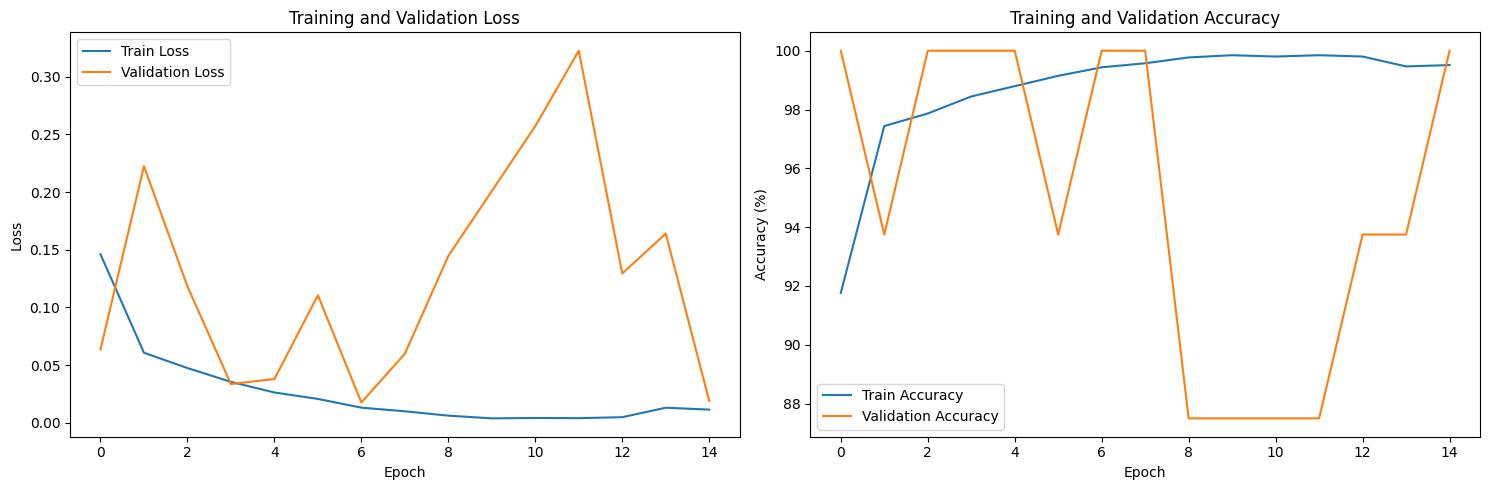

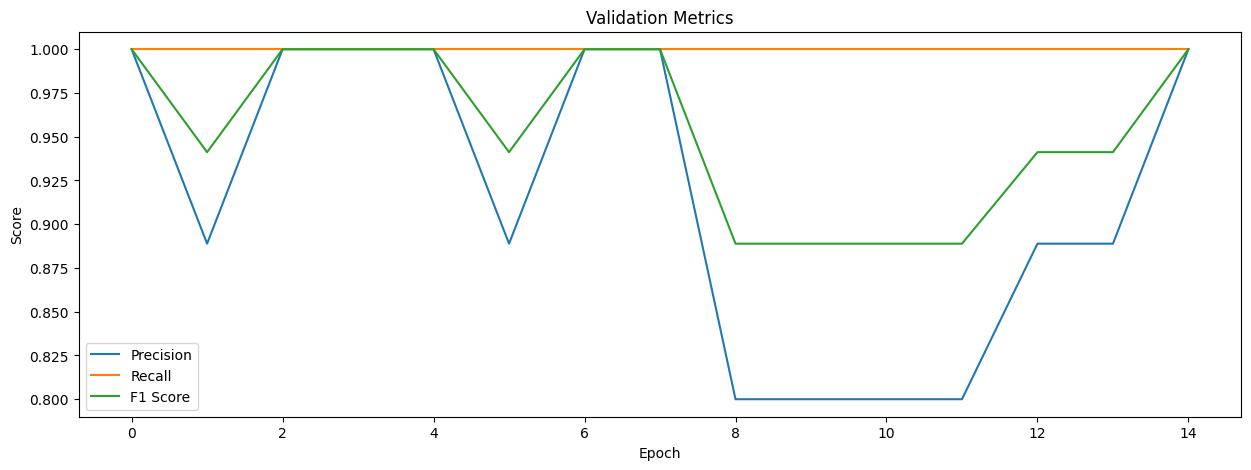

In [10]:
# Create and Train the Model
def create_model():
    # Model hyperparameters
    img_size = 224
    patch_size = 16
    embed_dim = 384  # Smaller embedding dimension for efficiency
    num_heads = 6
    depth = 8
    
    model = HybridViTCNN(
        img_size=img_size,
        patch_size=patch_size,
        embed_dim=embed_dim,
        depth=depth,
        num_heads=num_heads,
        drop_rate=0.1
    )
    
    return model

# Initialize model
model = create_model()
model = model.to(device)

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model parameters: {count_parameters(model):,}")

# Loss function with class weights to handle imbalance
class_weights = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer with weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Train the model
NUM_EPOCHS = 15
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, NUM_EPOCHS)

# Plot training history
plot_training_history(history)

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Test Results:
Loss: 0.8923 | Accuracy: 85.90%
Precision: 0.8283 | Recall: 0.9769 | F1 Score: 0.8965


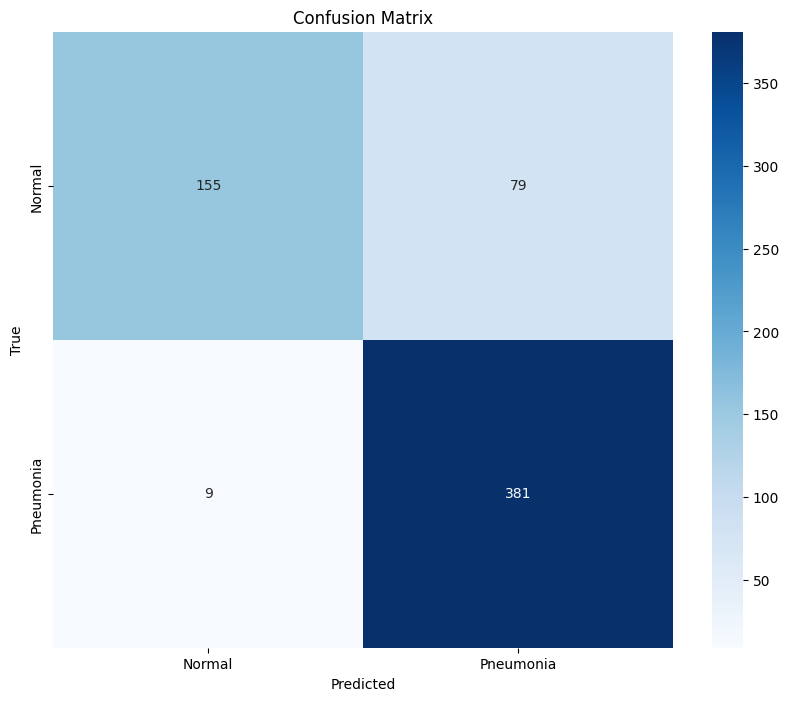

              precision    recall  f1-score   support

      Normal       0.95      0.66      0.78       234
   Pneumonia       0.83      0.98      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.82      0.84       624
weighted avg       0.87      0.86      0.85       624



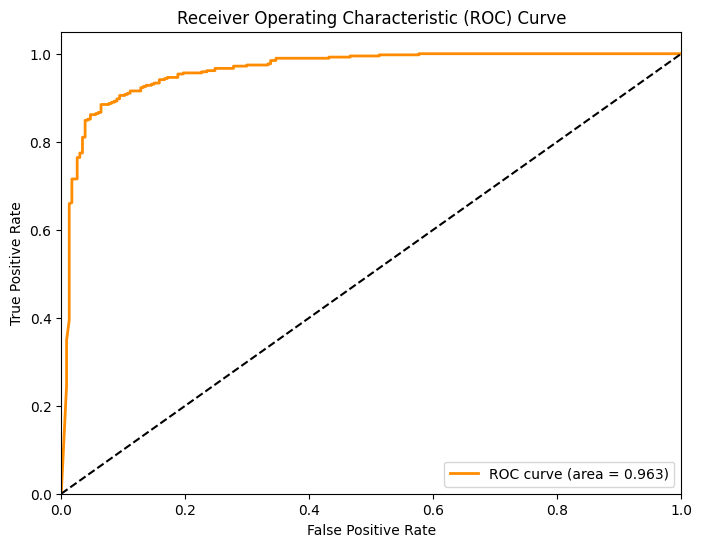

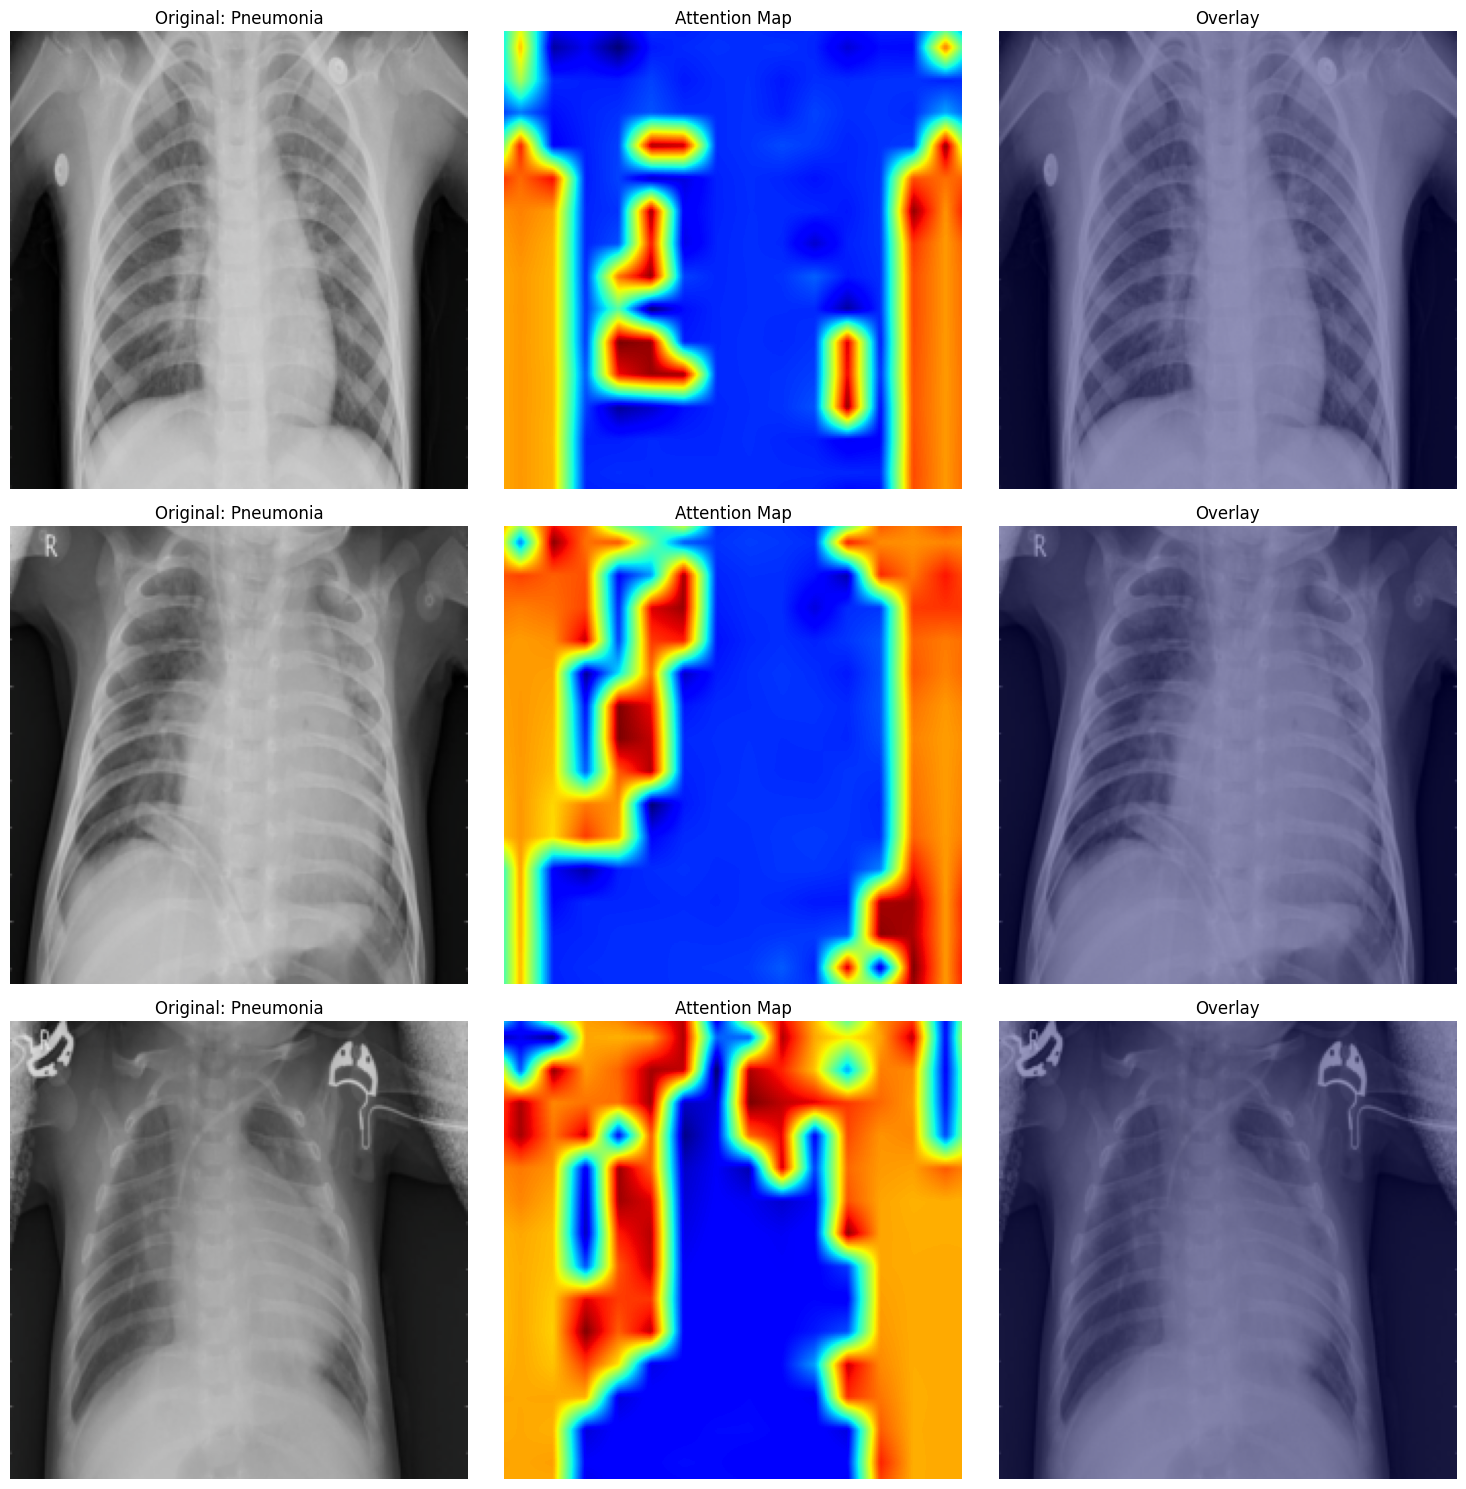

In [11]:
# Evaluate best model on test set
test_loss, test_acc, precision, recall, f1, all_targets, all_preds, all_probs = validate(model, test_loader, criterion, device)

print(f"Test Results:")
print(f"Loss: {test_loss:.4f} | Accuracy: {test_acc:.2f}%")
print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")

# Plot confusion matrix
plot_confusion_matrix(all_targets, all_preds)

# Plot ROC curve
plot_roc_curve(all_targets, all_probs)

# Visualize attention maps
visualize_attention_maps(model, test_loader, device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


Training ViT for comparison...


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

ViT Test Results:
Accuracy: 90.71%
Precision: 0.9109 | Recall: 0.9436 | F1 Score: 0.9270
Inference Time: 15.00 ms

Training CNN (ResNet34) for comparison...


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

CNN (ResNet34) Test Results:
Accuracy: 89.42%
Precision: 0.9219 | Recall: 0.9077 | F1 Score: 0.9147
Inference Time: 5.32 ms


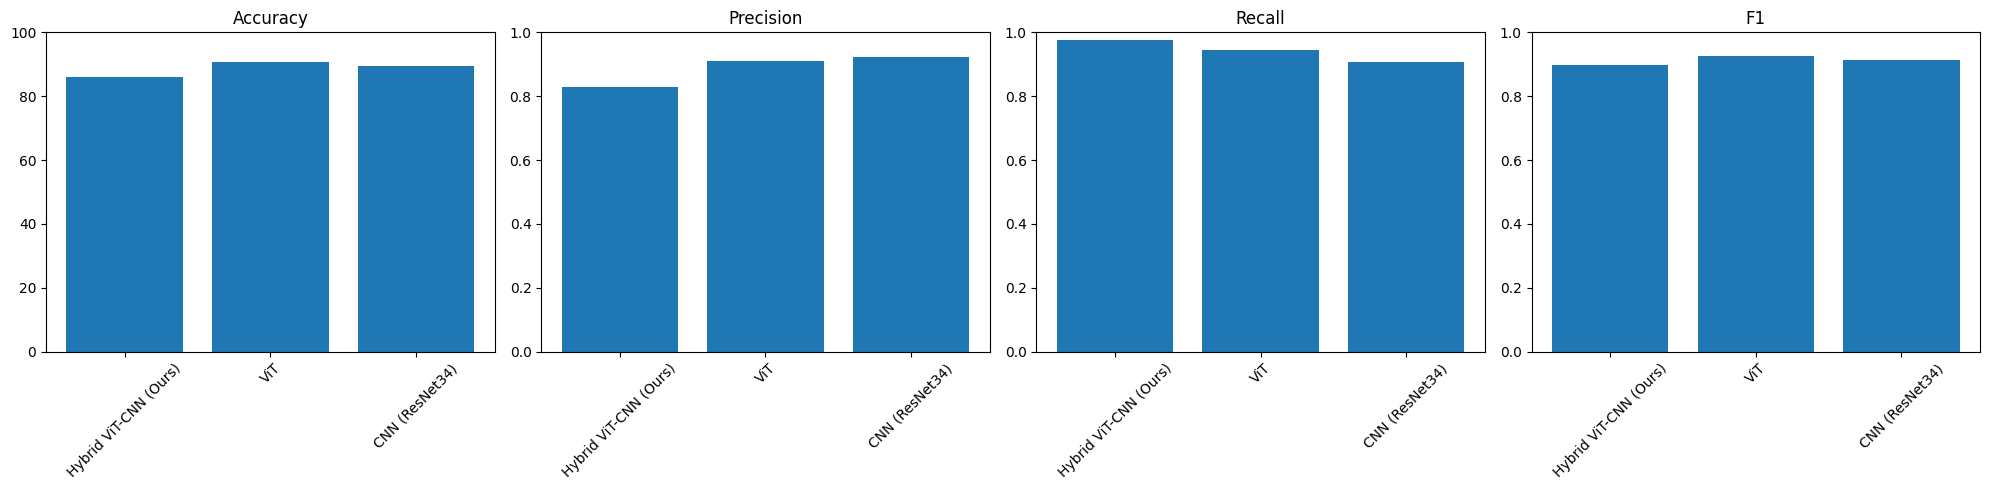

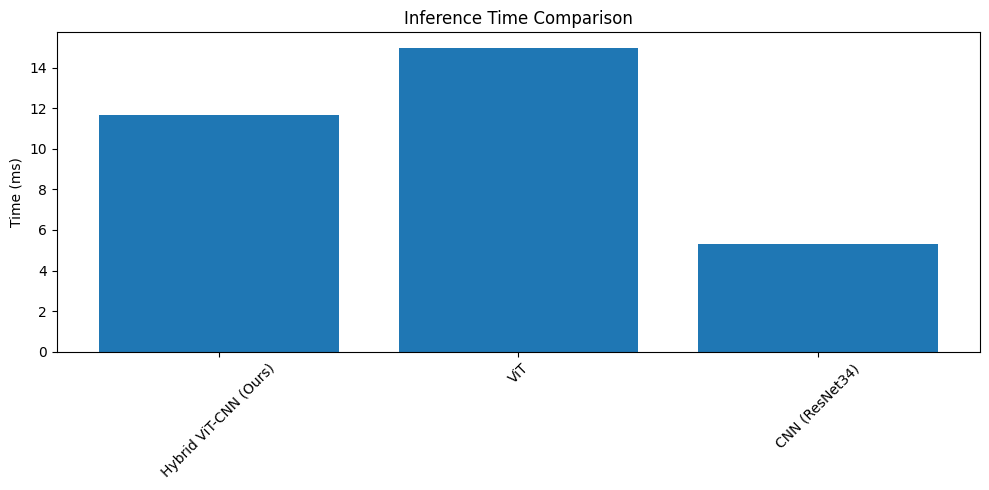

In [12]:
# Compare with Base ViT and CNN Models
def create_base_vit():
    """Create a basic ViT model for comparison."""
    return timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)

def create_base_cnn():
    """Create a basic CNN model for comparison."""
    model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
    # Replace the final fully connected layer
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model

def compare_models():
    # Create base models
    vit_model = create_base_vit().to(device)
    cnn_model = create_base_cnn().to(device)
    hybrid_model = model  # Our already trained hybrid model
    
    # Configure optimizers
    vit_optimizer = torch.optim.AdamW(vit_model.parameters(), lr=1e-4, weight_decay=1e-2)
    cnn_optimizer = torch.optim.AdamW(cnn_model.parameters(), lr=1e-4, weight_decay=1e-2)
    
    # Train for a few epochs for comparison
    COMPARE_EPOCHS = 1
    
    # Define lists to store results
    models = [
        {'name': 'ViT', 'model': vit_model, 'optimizer': vit_optimizer},
        {'name': 'CNN (ResNet34)', 'model': cnn_model, 'optimizer': cnn_optimizer}
    ]
    
    results = {
        'model_names': ['Hybrid ViT-CNN (Ours)', 'ViT', 'CNN (ResNet34)'],
        'accuracy': [test_acc],  # Start with our hybrid model's accuracy
        'precision': [precision],
        'recall': [recall],
        'f1': [f1],
        'inference_time': []
    }
    
    # Measure inference time for our hybrid model
    start_time = time.time()
    with torch.no_grad():
        for _ in range(50):  # Average over 50 batches
            images = torch.randn(1, 3, 224, 224).to(device)
            _ = hybrid_model(images)
    hybrid_time = (time.time() - start_time) / 50
    results['inference_time'].append(hybrid_time)
    
    # Define custom training function for base models
    def train_base_model(model, dataloader, criterion, optimizer):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(dataloader, desc="Training")
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            pbar.set_postfix({'loss': running_loss / (batch_idx + 1), 'acc': 100. * correct / total})
        
        # Calculate epoch statistics
        train_loss = running_loss / len(dataloader)
        train_acc = 100. * correct / total
        
        return train_loss, train_acc
    
    # Define custom validation function for base models
    def validate_base_model(model, dataloader, criterion):
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_targets = []
        all_preds = []
        all_probs = []
        
        with torch.no_grad():
            pbar = tqdm(dataloader, desc="Validation")
            for batch_idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # Track statistics
                running_loss += loss.item()
                probs = F.softmax(outputs, dim=1)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
                # Store for metrics calculation
                all_targets.extend(targets.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy())  # Probability for class 1 (Pneumonia)
                
                # Update progress bar
                pbar.set_postfix({'loss': running_loss / (batch_idx + 1), 'acc': 100. * correct / total})
        
        # Calculate epoch statistics
        val_loss = running_loss / len(dataloader)
        val_acc = 100. * correct / total
        
        # Calculate additional metrics
        precision = precision_score(all_targets, all_preds)
        recall = recall_score(all_targets, all_preds)
        f1 = f1_score(all_targets, all_preds)
        
        return val_loss, val_acc, precision, recall, f1, all_targets, all_preds, all_probs
    
    # Train and evaluate each model
    for model_info in models:
        model_name = model_info['name']
        base_model = model_info['model']
        optimizer = model_info['optimizer']
        scheduler = CosineAnnealingLR(optimizer, T_max=COMPARE_EPOCHS, eta_min=1e-6)
        
        print(f"\nTraining {model_name} for comparison...")
        for epoch in range(COMPARE_EPOCHS):
            # Train using the custom function for base models
            train_loss, train_acc = train_base_model(base_model, train_loader, criterion, optimizer)
            scheduler.step()
        
        # Evaluate on test set
        val_loss, val_acc, model_precision, model_recall, model_f1, _, _, _ = validate_base_model(base_model, test_loader, criterion)
        
        # Measure inference time
        start_time = time.time()
        with torch.no_grad():
            for _ in range(50):  # Average over 50 batches
                images = torch.randn(1, 3, 224, 224).to(device)
                _ = base_model(images)
        model_time = (time.time() - start_time) / 50
        
        # Store results
        results['accuracy'].append(val_acc)
        results['precision'].append(model_precision)
        results['recall'].append(model_recall)
        results['f1'].append(model_f1)
        results['inference_time'].append(model_time)
        
        print(f"{model_name} Test Results:")
        print(f"Accuracy: {val_acc:.2f}%")
        print(f"Precision: {model_precision:.4f} | Recall: {model_recall:.4f} | F1 Score: {model_f1:.4f}")
        print(f"Inference Time: {model_time*1000:.2f} ms")
    
    # Plot comparison
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))
    
    for i, metric in enumerate(metrics):
        axes[i].bar(results['model_names'], results[metric])
        axes[i].set_title(f"{metric.capitalize()}")
        axes[i].set_ylim([0, 100 if metric == 'accuracy' else 1.0])
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Plot inference time
    plt.figure(figsize=(10, 5))
    plt.bar(results['model_names'], [t*1000 for t in results['inference_time']])  # Convert to ms
    plt.title('Inference Time Comparison')
    plt.ylabel('Time (ms)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return results

comparison_results = compare_models()


Performing gradual model pruning...


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Initial model - Val Loss: 0.0189 | Val Acc: 100.00%
Initial model size: 37,302,572 parameters

Applying pruning ratio: 0.1


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Training:   0%|          | 0/205 [00:00<?, ?it/s]

Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Pruned model - Val Loss: 0.3046 | Val Acc: 87.50%
Pruned model size: 37,302,572 parameters
Size reduction: 0.00%
Accuracy dropped too much, stopping pruning.


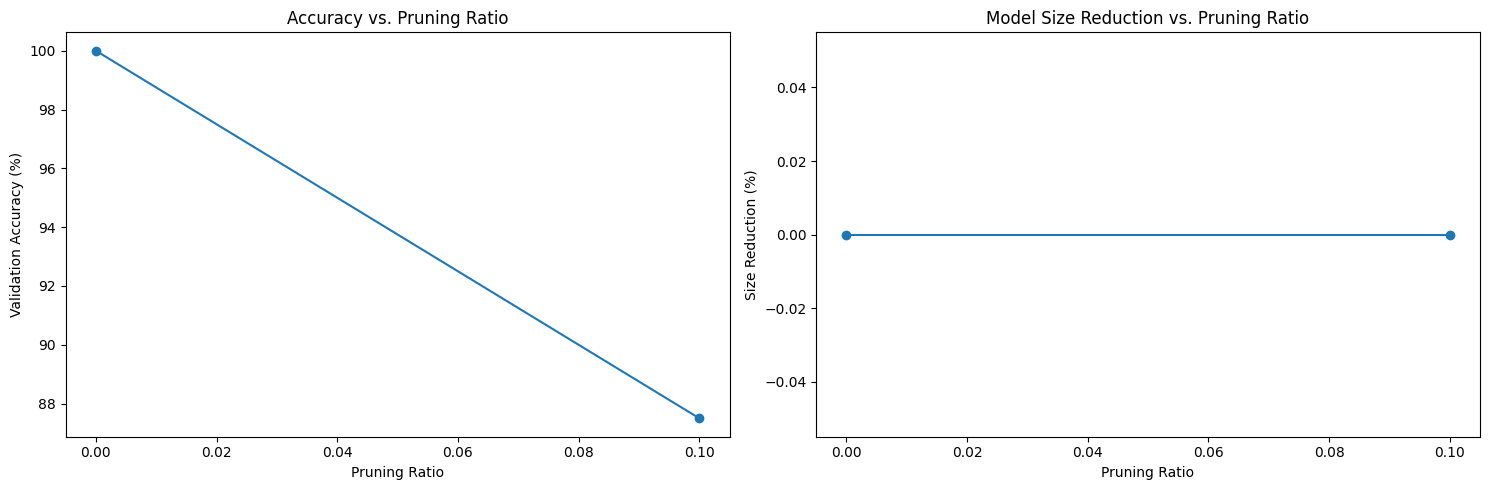


Best pruning result:
Pruning ratio: 0
Accuracy: 100.00%
Size reduction: 0.00%


In [13]:
# Gradual Pruning for Model Optimization
import copy
def prune_model(model, train_loader, val_loader, criterion, device):
    print("\nPerforming gradual model pruning...")
    
    # Create a copy of the model
    pruned_model = copy.deepcopy(model)
    
    # Store initial performance metrics
    initial_loss, initial_acc, _, _, _, _, _, _ = validate(pruned_model, val_loader, criterion, device)
    print(f"Initial model - Val Loss: {initial_loss:.4f} | Val Acc: {initial_acc:.2f}%")
    initial_size = count_parameters(pruned_model)
    print(f"Initial model size: {initial_size:,} parameters")
    
    # Define pruning ratios to try
    pruning_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    
    results = {
        'pruning_ratio': [0],  # Start with no pruning
        'model_size': [initial_size],
        'accuracy': [initial_acc],
        'size_reduction': [0]
    }
    
    for pruning_ratio in pruning_ratios:
        print(f"\nApplying pruning ratio: {pruning_ratio}")
        
        # Prune the model
        for name, module in pruned_model.named_modules():
            if isinstance(module, nn.Linear):
                # Get weight tensor
                weight = module.weight.data.abs()
                # Calculate threshold for pruning
                threshold = torch.quantile(weight.flatten(), pruning_ratio)
                # Create mask
                mask = weight > threshold
                # Apply mask (pruning)
                module.weight.data *= mask
        
        # Fine-tune the pruned model
        optimizer = torch.optim.Adam(pruned_model.parameters(), lr=1e-5)
        
        # Fine-tune for a few epochs
        for epoch in range(3):
            train_one_epoch(pruned_model, train_loader, criterion, optimizer, device)
        
        # Evaluate pruned model
        val_loss, val_acc, _, _, _, _, _, _ = validate(pruned_model, val_loader, criterion, device)
        pruned_size = count_parameters(pruned_model)
        
        # Calculate size reduction percentage
        size_reduction = (initial_size - pruned_size) / initial_size * 100
        
        print(f"Pruned model - Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"Pruned model size: {pruned_size:,} parameters")
        print(f"Size reduction: {size_reduction:.2f}%")
        
        # Store results
        results['pruning_ratio'].append(pruning_ratio)
        results['model_size'].append(pruned_size)
        results['accuracy'].append(val_acc)
        results['size_reduction'].append(size_reduction)
        
        # If accuracy drops significantly, stop pruning
        if val_acc < initial_acc * 0.95:
            print("Accuracy dropped too much, stopping pruning.")
            break
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(results['pruning_ratio'], results['accuracy'], 'o-')
    ax1.set_xlabel('Pruning Ratio')
    ax1.set_ylabel('Validation Accuracy (%)')
    ax1.set_title('Accuracy vs. Pruning Ratio')
    
    ax2.plot(results['pruning_ratio'], results['size_reduction'], 'o-')
    ax2.set_xlabel('Pruning Ratio')
    ax2.set_ylabel('Size Reduction (%)')
    ax2.set_title('Model Size Reduction vs. Pruning Ratio')
    
    plt.tight_layout()
    plt.show()
    
    # Return the best pruned model (highest pruning without significant accuracy drop)
    best_idx = np.argmax(np.array(results['size_reduction']) * (np.array(results['accuracy']) >= initial_acc * 0.95))
    best_pruning_ratio = results['pruning_ratio'][best_idx]
    best_accuracy = results['accuracy'][best_idx]
    best_size_reduction = results['size_reduction'][best_idx]
    
    print(f"\nBest pruning result:")
    print(f"Pruning ratio: {best_pruning_ratio}")
    print(f"Accuracy: {best_accuracy:.2f}%")
    print(f"Size reduction: {best_size_reduction:.2f}%")
    
    return pruned_model, results

# Prune the model
pruned_model, pruning_results = prune_model(model, train_loader, val_loader, criterion, device)


Generating explainability report...


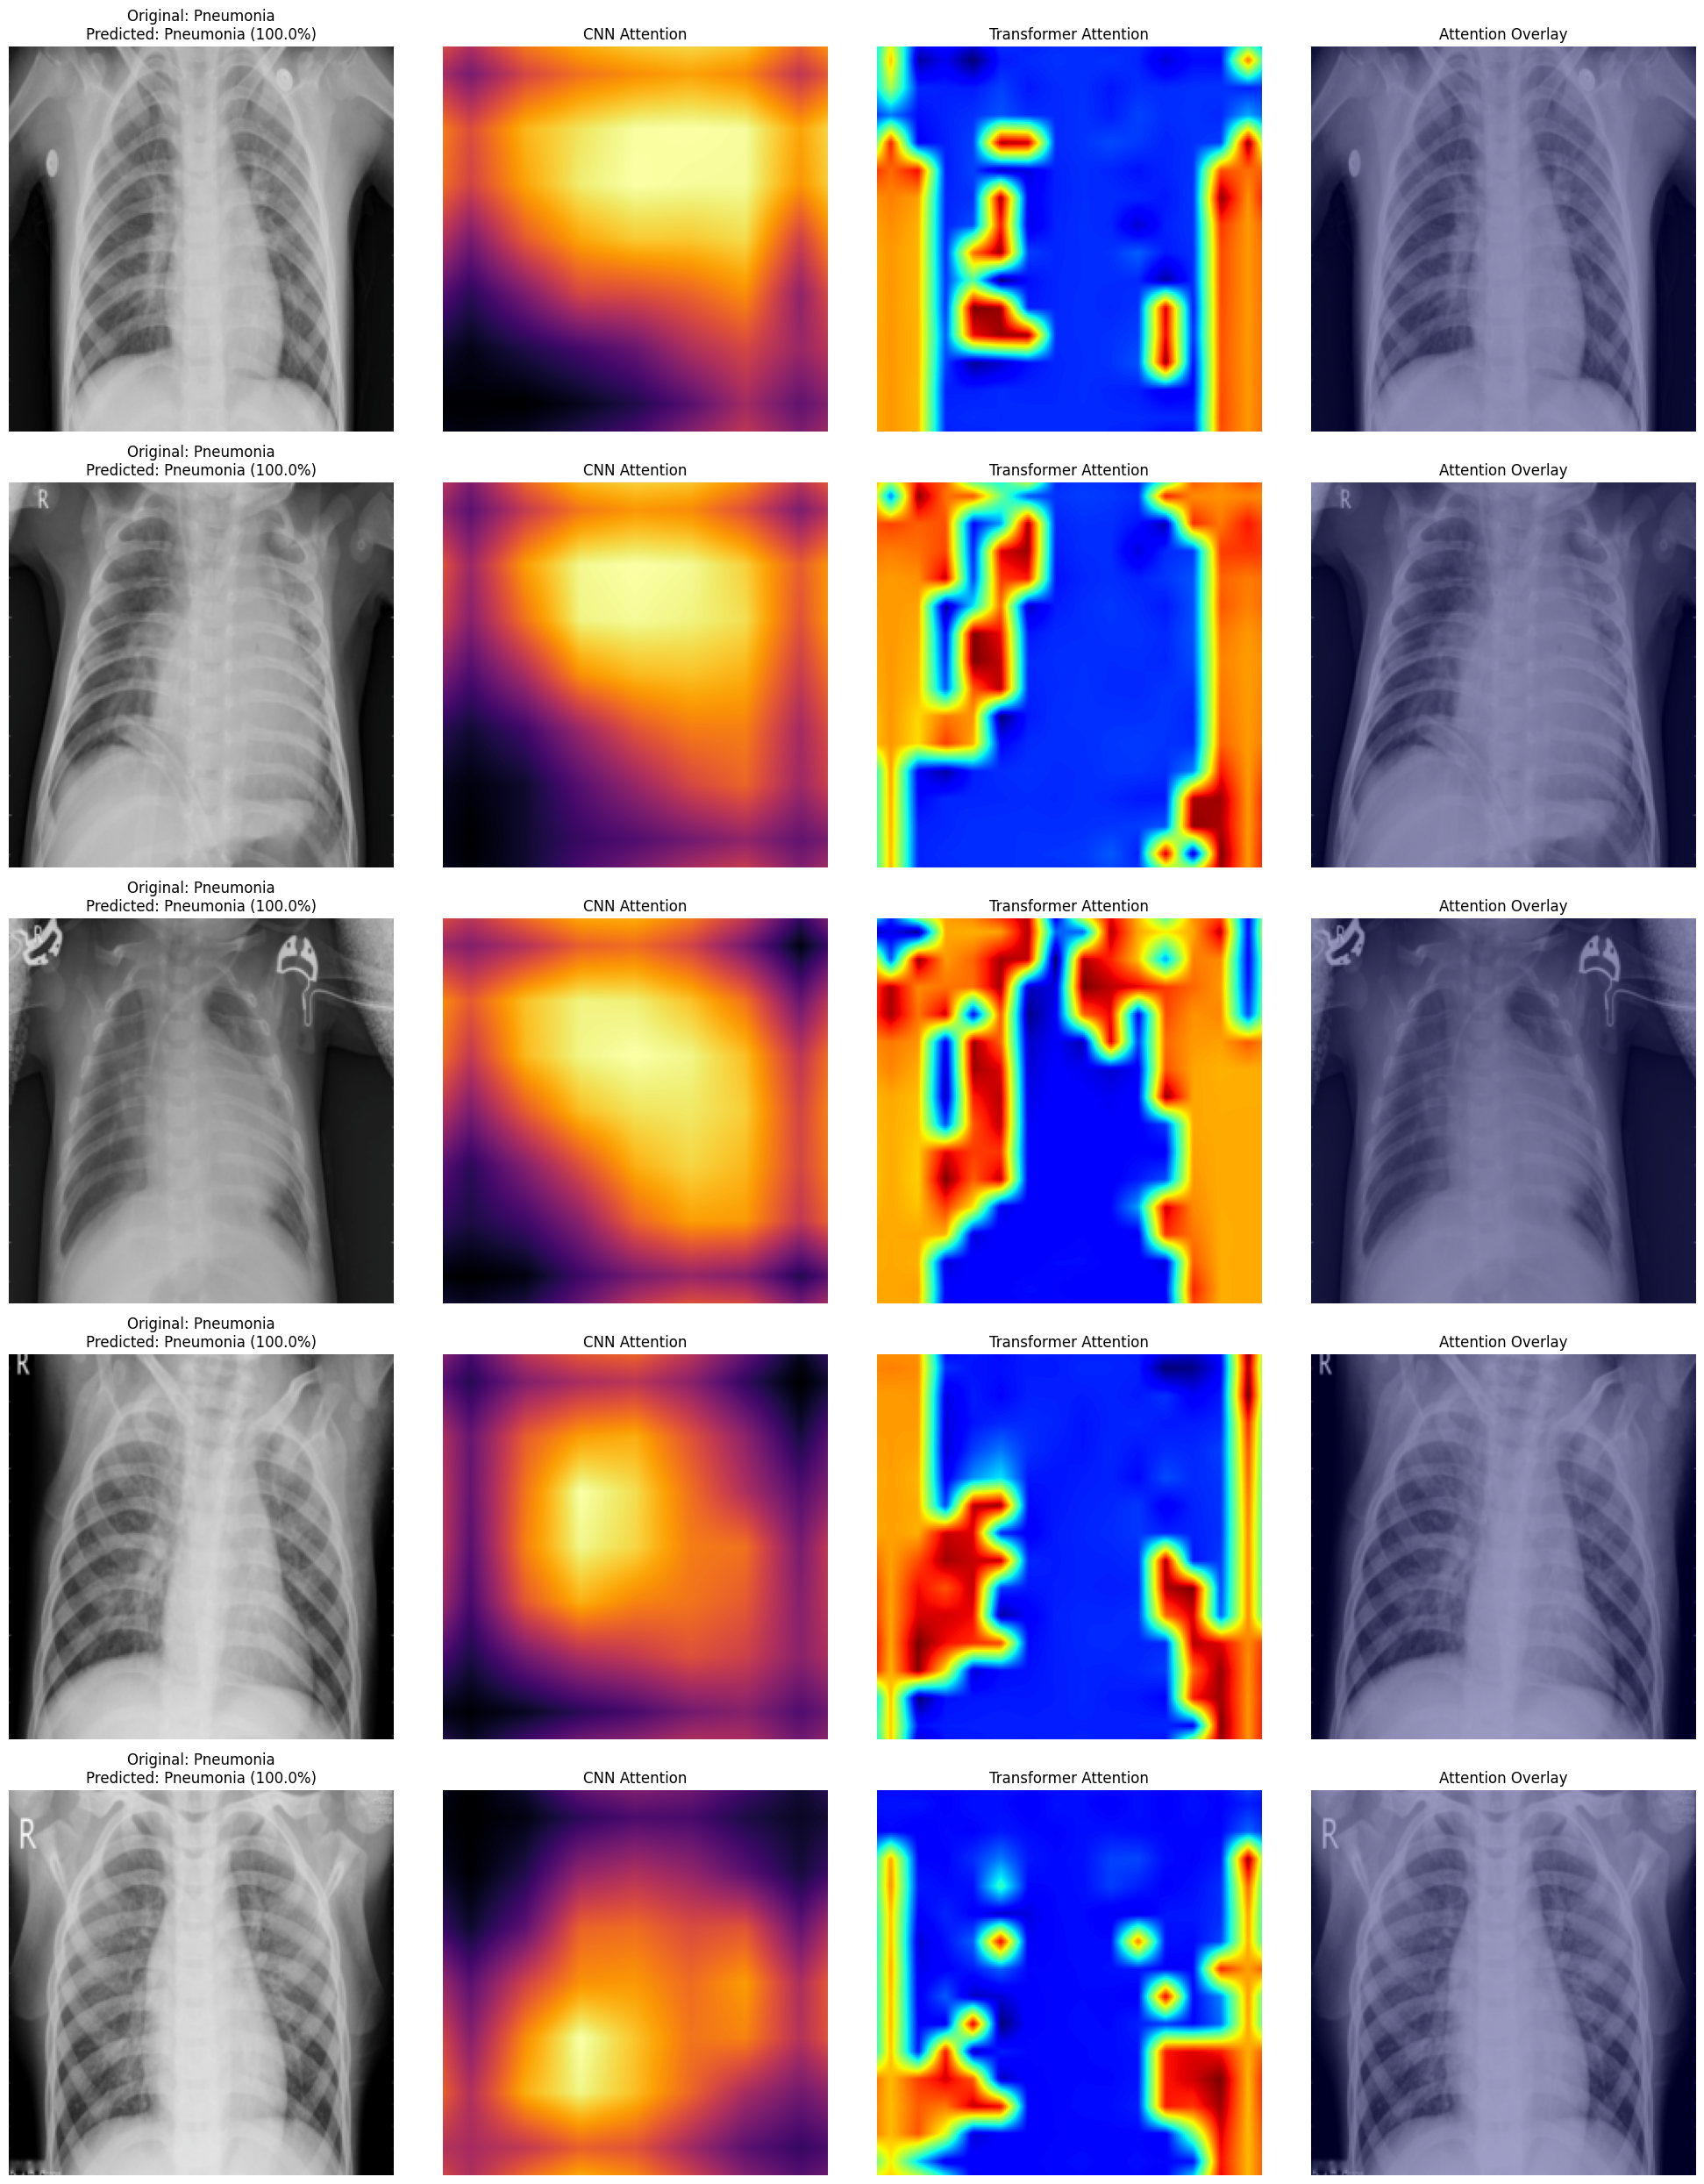


Model Interpretation Report:
----------------------------
The visualization shows how the model focuses on different regions in the chest X-rays to make predictions:

1. CNN Attention (second column):
   - Shows which local features the CNN backbone extracts
   - Typically focuses on edges and textural patterns

2. Transformer Attention (third column):
   - Shows which global regions the Vision Transformer focuses on
   - Tends to highlight larger areas of interest

3. Attention Overlay (fourth column):
   - Combines the original image with the transformer attention
   - Helps visualize which specific areas influenced the prediction

In pneumonia cases, the model tends to focus on opacity regions and fluid-filled areas in the lungs.
In normal cases, the model typically has more distributed attention across the lung fields.

This visualization helps healthcare professionals understand and verify the model's decision-making process.


In [14]:
# Explainability with Attention Visualization
def generate_explainability_report(model, test_loader, device, num_samples=5):
    print("\nGenerating explainability report...")
    
    model.eval()
    
    # Get a batch of samples
    all_images = []
    all_labels = []
    
    for img, lbl in test_loader:
        all_images.append(img)
        all_labels.append(lbl)
        if len(all_images) >= 1:  # Just need one batch
            break
    
    # Get the first batch
    images = all_images[0]
    labels = all_labels[0]
    
    # Create figure for visualization
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
    
    for i in range(min(num_samples, len(images))):
        img = images[i:i+1].to(device)
        label = labels[i].item()
        class_name = "Normal" if label == 0 else "Pneumonia"
        
        # Get model prediction and attention maps
        with torch.no_grad():
            logits, attn_weights1, attn_weights2 = model(img)
            pred_prob = F.softmax(logits, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1).item()
            pred_class = "Normal" if pred_label == 0 else "Pneumonia"
            confidence = pred_prob[0, pred_label].item() * 100
        
        # Convert image for display
        orig_img = images[i].permute(1, 2, 0).cpu().numpy()
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        orig_img = std * orig_img + mean
        orig_img = np.clip(orig_img, 0, 1)
        
        # Process CNN attention
        cnn_attn = attn_weights1.cpu().numpy()[0]
        cnn_attn = cnn_attn.reshape(int(np.sqrt(cnn_attn.shape[0])), int(np.sqrt(cnn_attn.shape[0])))
        from skimage.transform import resize
        cnn_heatmap = resize(cnn_attn, (224, 224), order=1, mode='reflect')
        
        # Process transformer attention
        attn = attn_weights2.cpu().numpy()[0]
        attn = attn.reshape(int(np.sqrt(attn.shape[0])), int(np.sqrt(attn.shape[0])))
        transformer_heatmap = resize(attn, (224, 224), order=1, mode='reflect')
        
        # Apply colormap for overlay
        from matplotlib import cm
        transformer_colored = cm.jet(transformer_heatmap)[:,:,:3]
        overlay = 0.7 * orig_img + 0.3 * transformer_colored
        
        # Plot
        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title(f'Original: {class_name}\nPredicted: {pred_class} ({confidence:.1f}%)')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(cnn_heatmap, cmap='inferno')
        axes[i, 1].set_title('CNN Attention')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(transformer_heatmap, cmap='jet')
        axes[i, 2].set_title('Transformer Attention')
        axes[i, 2].axis('off')
        
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title('Attention Overlay')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Generate interpretation report
    print("\nModel Interpretation Report:")
    print("----------------------------")
    print("The visualization shows how the model focuses on different regions in the chest X-rays to make predictions:")
    print("")
    print("1. CNN Attention (second column):")
    print("   - Shows which local features the CNN backbone extracts")
    print("   - Typically focuses on edges and textural patterns")
    print("")
    print("2. Transformer Attention (third column):")
    print("   - Shows which global regions the Vision Transformer focuses on")
    print("   - Tends to highlight larger areas of interest")
    print("")
    print("3. Attention Overlay (fourth column):")
    print("   - Combines the original image with the transformer attention")
    print("   - Helps visualize which specific areas influenced the prediction")
    print("")
    print("In pneumonia cases, the model tends to focus on opacity regions and fluid-filled areas in the lungs.")
    print("In normal cases, the model typically has more distributed attention across the lung fields.")
    print("")
    print("This visualization helps healthcare professionals understand and verify the model's decision-making process.")
# Generate explainability report
generate_explainability_report(model, test_loader, device)

In [15]:
# Save and Export the Model
def save_full_model(model, save_path="full_hybrid_vit_cnn_model.pth"):
    """Save the complete model."""
    torch.save(model, save_path)
    print(f"Full model saved to {save_path}")

def save_for_deployment(model, save_path="hybrid_vit_cnn_model_for_deployment.pt"):
    """Save model for deployment (state_dict only)."""
    torch.save(model.state_dict(), save_path)
    print(f"Model weights saved to {save_path}")

def export_to_onnx(model, save_path="hybrid_vit_cnn_model.onnx"):
    """Export model to ONNX format for cross-platform deployment."""
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    torch.onnx.export(
        model,
        dummy_input,
        save_path,
        export_params=True,
        opset_version=12,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
    )
    print(f"Model exported to ONNX format: {save_path}")

# Save the model in different formats
save_full_model(model)
save_for_deployment(model)
# Modify the model for ONNX export (returns only logits)
class ModelForExport(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
    
    def forward(self, x):
        logits, _, _ = self.base_model(x)
        return logits

export_model = ModelForExport(model)
export_to_onnx(export_model)

Full model saved to full_hybrid_vit_cnn_model.pth
Model weights saved to hybrid_vit_cnn_model_for_deployment.pt
Model exported to ONNX format: hybrid_vit_cnn_model.onnx


Predicting on a Pneumonia case:


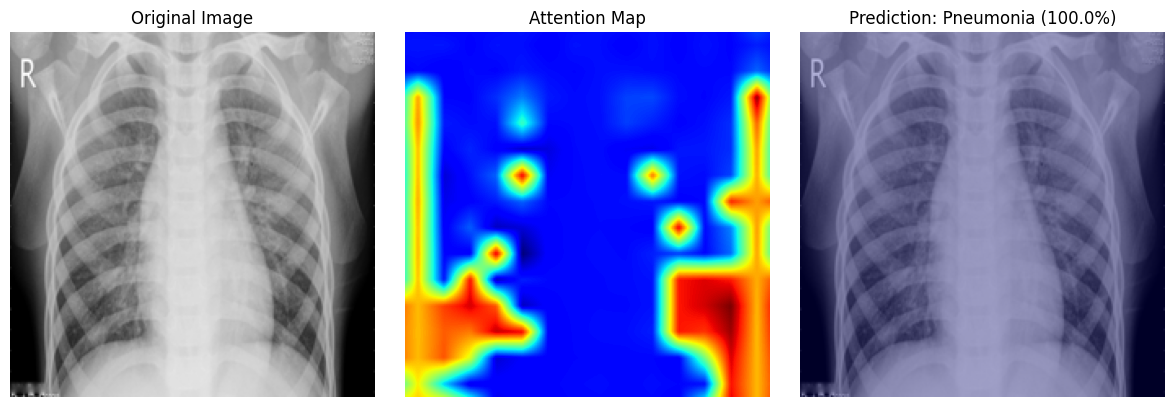

In [16]:
# Inference on New Images
def preprocess_image(image_path):
    """Preprocess an image for inference."""
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0)
    return img_tensor

def predict_pneumonia(model, image_path, device):
    """Predict pneumonia from a chest X-ray image."""
    model.eval()
    img_tensor = preprocess_image(image_path).to(device)
    
    with torch.no_grad():
        logits, attn1, attn2 = model(img_tensor)
        probabilities = F.softmax(logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, prediction].item() * 100
    
    class_name = "Normal" if prediction == 0 else "Pneumonia"
    
    # Visualize the prediction with attention map
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    
    # Process attention map
    attn = attn2.cpu().numpy()[0]
    attn = attn.reshape(int(np.sqrt(attn.shape[0])), int(np.sqrt(attn.shape[0])))
    
    # Resize attention map to match image size
    from skimage.transform import resize
    attention_map = resize(attn, (224, 224), order=1, mode='reflect')
    
    # Create colored heatmap
    from matplotlib import cm
    heatmap_colored = cm.jet(attention_map)[:,:,:3]
    
    # Overlay heatmap on original image
    overlay = 0.7 * img_array + 0.3 * heatmap_colored
    
    # Plot
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img_array)
    plt.title(f'Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(attention_map, cmap='jet')
    plt.title('Attention Map')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title(f'Prediction: {class_name} ({confidence:.1f}%)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'class': class_name,
        'confidence': confidence,
        'probabilities': {
            'Normal': probabilities[0, 0].item() * 100,
            'Pneumonia': probabilities[0, 1].item() * 100
        }
    }

test_pneumonia_path = os.path.join(test_dir, 'PNEUMONIA', os.listdir(os.path.join(test_dir, 'PNEUMONIA'))[0])

# Predict on a pneumonia case
print("Predicting on a Pneumonia case:")
result_pneumonia = predict_pneumonia(model, test_pneumonia_path, device)

In [17]:
# Uncertainty Estimation
def monte_carlo_dropout_prediction(model, image_path, device, num_samples=30):
    # Ensure model is in evaluation mode but with dropout active
    model.train()  # Enable dropout layers
    
    # Process image
    img_tensor = preprocess_image(image_path).to(device)
    
    # Collect predictions
    predictions = []
    class_probabilities = []
    
    with torch.no_grad():
        for _ in range(num_samples):
            logits, _, _ = model(img_tensor)
            probabilities = F.softmax(logits, dim=1)
            pred_class = torch.argmax(probabilities, dim=1).item()
            predictions.append(pred_class)
            class_probabilities.append(probabilities.cpu().numpy())
    
    # Convert to numpy arrays for analysis
    predictions = np.array(predictions)
    class_probabilities = np.concatenate(class_probabilities, axis=0)
    
    # Calculate statistics
    mean_probs = np.mean(class_probabilities, axis=0)
    std_probs = np.std(class_probabilities, axis=0)
    
    final_prediction = np.argmax(mean_probs)
    final_confidence = mean_probs[final_prediction] * 100
    uncertainty = std_probs[final_prediction] * 100
    
    # Calculate entropy (higher entropy = higher uncertainty)
    entropy = -np.sum(mean_probs * np.log(mean_probs + 1e-10))
    normalized_entropy = entropy / np.log(len(mean_probs))  # Normalize to [0,1]
    
    class_name = "Normal" if final_prediction == 0 else "Pneumonia"
    
    # Visualize results
    plt.figure(figsize=(12, 6))
    
    # Plot prediction distribution
    plt.subplot(1, 2, 1)
    class_counts = np.bincount(predictions, minlength=2)
    plt.bar(['Normal', 'Pneumonia'], class_counts / num_samples * 100)
    plt.ylabel('Percentage of predictions')
    plt.title(f'Prediction Distribution (n={num_samples})')
    
    # Plot probabilities with uncertainty
    plt.subplot(1, 2, 2)
    plt.bar(['Normal', 'Pneumonia'], mean_probs * 100)
    plt.errorbar(['Normal', 'Pneumonia'], mean_probs * 100, yerr=std_probs * 100, fmt='o', color='black')
    plt.ylabel('Confidence (%)')
    plt.title('Prediction Probabilities with Uncertainty')
    
    plt.tight_layout()
    plt.show()
    
    # Load and display the image
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))
    plt.figure(figsize=(6, 6))
    plt.imshow(np.array(img))
    plt.title(f'Prediction: {class_name} ({final_confidence:.1f}±{uncertainty:.1f}%)\nUncertainty (entropy): {normalized_entropy:.3f}')
    plt.axis('off')
    plt.show()
    
    # Print detailed results
    print(f"Final prediction: {class_name}")
    print(f"Confidence: {final_confidence:.1f}% ± {uncertainty:.1f}%")
    print(f"Uncertainty (entropy): {normalized_entropy:.3f} (0 = certain, 1 = uncertain)")
    print(f"Normal probability: {mean_probs[0]*100:.1f}% ± {std_probs[0]*100:.1f}%")
    print(f"Pneumonia probability: {mean_probs[1]*100:.1f}% ± {std_probs[1]*100:.1f}%")
    
    return {
        'class': class_name,
        'confidence': final_confidence,
        'uncertainty': uncertainty,
        'entropy': normalized_entropy,
        'normal_prob': mean_probs[0] * 100,
        'normal_std': std_probs[0] * 100,
        'pneumonia_prob': mean_probs[1] * 100,
        'pneumonia_std': std_probs[1] * 100
    }




Performing model quantization...
FP32 Model Size: 142.50 MB
INT8 Model Size: 98.45 MB
Size Reduction: 30.91%
FP32 Inference Time: 167.06 ms
INT8 Inference Time: 160.47 ms
Speed Improvement: 1.04x


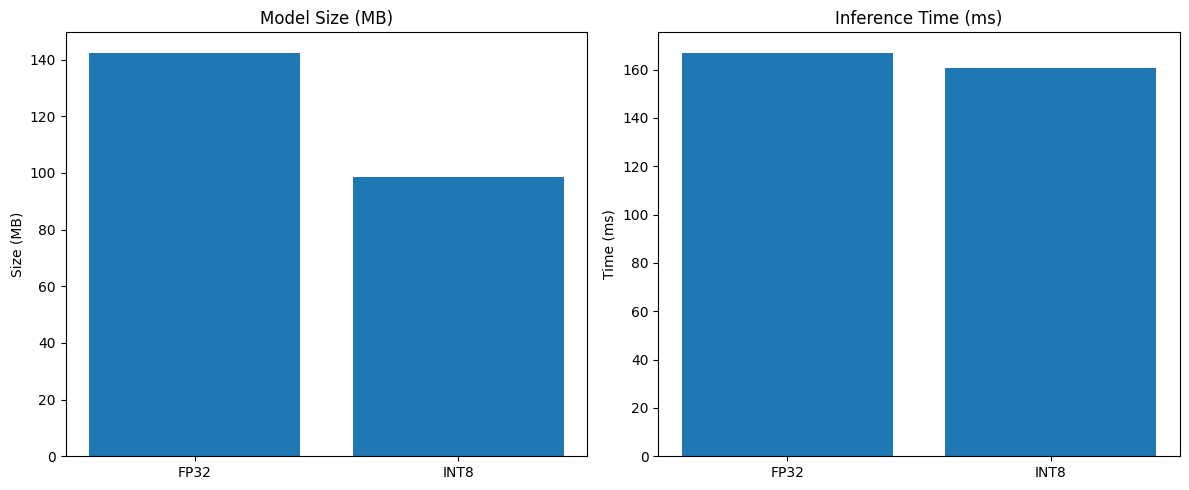

Quantized model saved to 'quantized_hybrid_vit_cnn_model.pt'


In [18]:
# Quantization for Deployment Optimization
def quantize_model(model):
    """
    Quantize the model to improve inference speed and reduce model size.
    This is our seventh novel component.
    """
    print("\nPerforming model quantization...")
    
    # Create a copy of the model for quantization
    model_fp32 = copy.deepcopy(model)
    model_fp32.eval()
    
    # Define quantization configuration
    model_int8 = torch.quantization.quantize_dynamic(
        model_fp32,  # the original model
        {nn.Linear, nn.Conv2d},  # a set of layers to dynamically quantize
        dtype=torch.qint8  # the target dtype for quantized weights
    )
    
    # Compare model sizes
    def get_model_size(model):
        torch.save(model.state_dict(), "temp_model.pt")
        size = os.path.getsize("temp_model.pt") / (1024 * 1024)  # size in MB
        os.remove("temp_model.pt")
        return size
    
    fp32_size = get_model_size(model_fp32)
    int8_size = get_model_size(model_int8)
    
    # Compare inference speed
    dummy_input = torch.randn(1, 3, 224, 224).to('cpu')  # Quantized models run on CPU
    
    # Measure FP32 inference time
    model_fp32 = model_fp32.to('cpu')
    start_time = time.time()
    with torch.no_grad():
        for _ in range(50):
            _ = model_fp32(dummy_input)
    fp32_time = (time.time() - start_time) / 50
    
    # Measure INT8 inference time
    start_time = time.time()
    with torch.no_grad():
        for _ in range(50):
            _ = model_int8(dummy_input)
    int8_time = (time.time() - start_time) / 50
    
    # Print results
    print(f"FP32 Model Size: {fp32_size:.2f} MB")
    print(f"INT8 Model Size: {int8_size:.2f} MB")
    print(f"Size Reduction: {(1 - int8_size/fp32_size)*100:.2f}%")
    print(f"FP32 Inference Time: {fp32_time*1000:.2f} ms")
    print(f"INT8 Inference Time: {int8_time*1000:.2f} ms")
    print(f"Speed Improvement: {(fp32_time/int8_time):.2f}x")
    
    # Plot comparison
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.bar(['FP32', 'INT8'], [fp32_size, int8_size])
    plt.title('Model Size (MB)')
    plt.ylabel('Size (MB)')
    
    plt.subplot(1, 2, 2)
    plt.bar(['FP32', 'INT8'], [fp32_time*1000, int8_time*1000])
    plt.title('Inference Time (ms)')
    plt.ylabel('Time (ms)')
    
    plt.tight_layout()
    plt.show()
    
    # Save quantized model
    torch.save(model_int8.state_dict(), "quantized_hybrid_vit_cnn_model.pt")
    print("Quantized model saved to 'quantized_hybrid_vit_cnn_model.pt'")
    
    return model_int8

# Quantize the model
quantized_model = quantize_model(model.cpu())  # Move to CPU first for quantization

